# Clusterless Decoding Implementation

### Simulating the position data

We first simulate the position of the mouse running back and fourth along a linear track with the following transition probability

$p(x_k | x_{k-1}) \sim N(\alpha x_{k-1}, \sigma)$

In [1]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

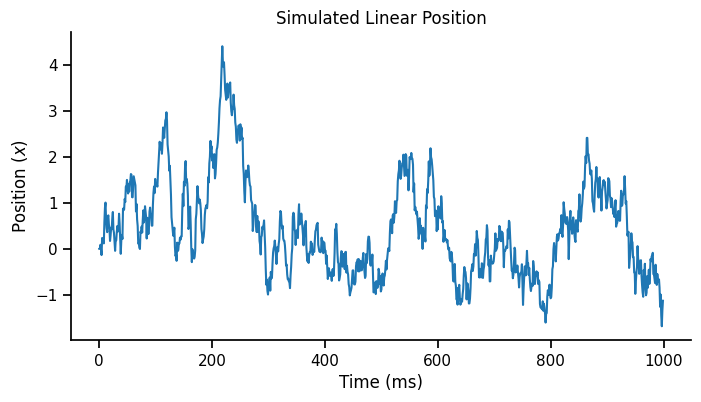

In [2]:
alpha = 0.98
sigma = 0.05
n_timesteps = 1000
x = np.zeros(n_timesteps)
for k in range(n_timesteps - 1):
    x[k + 1] = np.random.normal(alpha * x[k], np.sqrt(sigma))

plt.figure(figsize=(8, 4))
sns.lineplot(x)
plt.xlabel('Time (ms)')
plt.ylabel('Position $(x)$')
plt.title('Simulated Linear Position')
sns.despine()
plt.show()


### Defining functions to describe spiking activity and associated marks

We now define our simulation joint mark intensity $\lambda(t, \vec{m})$ of two hippocampal place cells using a bivariate Gaussian mixture function as in Eq. 8




In [3]:
def joint_mark_intensity(x, m, mu_x, mu_m, sigma_x, sigma_m, a):
    '''
    The joint mark intensity function for our simulation model.
    '''
    
    jmi = 0
    for c in [0,1]:
        jmi += np.exp((a[c]- (x - mu_x[c])**2) / (2*sigma_x[c]**2)  -  ((m - mu_m[c])**2) / (2*sigma_m[c]**2))
        
    return jmi



We integrate the joint mark intensity over the mark space $M$ to get our ground process rate $ \Lambda(t) = \int_M \lambda(t, \vec{m})dm$ 

In [4]:
def ground_process_rate(x, mu_x, sigma_x, a):
    '''
    The ground process for our simulation model, which is the integral of the joint mark intensity function with respect to m.
    '''

    rate = 0
    for c in [0,1]:
        rate += np.exp(a[c]) * np.exp(-((x - mu_x[c])**2) / (2*sigma_x[c]**2))
    
    return rate
    


We also need to define a function to simulate the inhomogeneous Poisson process using the ground process rate. We use the thinning algorithm below.

In [5]:

def HomogeneousPoisson(rate, t_old):
    """
    Generate a new event time for a homogeneous Poisson process.
    """
    u = np.random.rand()
    t_new = -np.log(u) / rate + t_old
    return t_new

def InHomoPoisson(rate, t_old):
    """
    Simulate an inhomogeneous Poisson process using the thinning algorithm.
    """
    gmax = np.max(rate)  # Upper bound for thinning

    while True:
        # Generate a candidate event time from the homogeneous Poisson process
        t = HomogeneousPoisson(gmax, t_old)

        # Check if time exceeds rate length (end of simulation)
        if t >= len(rate):
            return None  # Signal end of process

        # Interpolate the rate at the candidate time
        rate_value = np.interp(t, np.arange(len(rate)), rate)

        # Thinning: Accept or reject the event
        u = np.random.rand()
        if u * gmax < rate_value:
            return t  # Event accepted
        else:
            t_old = t  # Update the last time and continue
            


Finally, we can define the pdf from which the marks associated with the spike train which are sampled $f(\vec{m}|t) = \frac{\lambda(t, \vec{m})}{\Lambda(t|H_t)}$

In [6]:
def marks_pdf(m, t, x, mu_x, mu_m, sigma_x, sigma_m, a):
    '''
    The marks pdf for our simulation model which is the joint mark intensity divided by the ground process rate.
    '''
    
    return joint_mark_intensity(x[t], m, mu_x, mu_m, sigma_x, sigma_m, a) / ground_process_rate(x[t], mu_x, sigma_x, a)

### Simulating the neural data

Now that our functions are defined, the first thing to do is simulate our ground process rate $ \Lambda(t)$

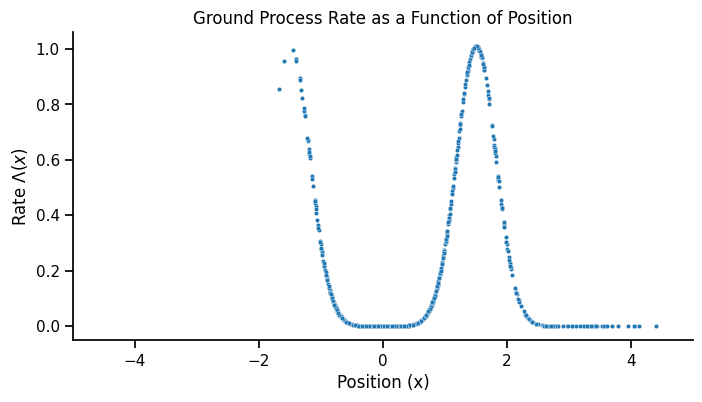

In [7]:
# Defining the parameters of the simulation model
mu_x = [-1.5, 1.5]
sigma_x = [np.sqrt(0.1), np.sqrt(0.1)]
a = [0.01, 0.01]
mu_m = [10, 13]
sigma_m = [2,2]

# simulating the ground process rate
rate = np.zeros(n_timesteps)
for k in range(n_timesteps):
    rate[k] = ground_process_rate(x[k], mu_x, sigma_x, a)


# Plotting the ground process rate as a function of position
plt.figure(figsize=(8, 4))
sns.scatterplot(x = x, y = rate, s = 10)
plt.xlabel("Position (x)")
plt.ylabel("Rate $\\Lambda(x)$")
plt.title("Ground Process Rate as a Function of Position")
plt.xlim(-5, 5)
sns.despine()
plt.show()

Now we can use the ground process rate to simulate the spike times using an inhomogeneous Poisson process.

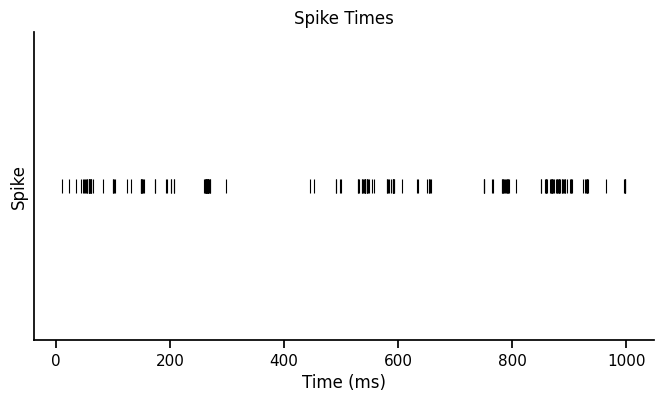

In [8]:
spike_times = []
t = 0
while t < n_timesteps:
    t = InHomoPoisson(rate, t)
    if t is not None:
        spike_times.append(t)
    else:
        break


# plotting the spike times
plt.figure(figsize = (8, 4))
sns.scatterplot(x=spike_times, y=np.ones(len(spike_times)), marker='|', s=100, color='k')
plt.xlabel('Time (ms)')
plt.ylabel('Spike')
plt.yticks([])
plt.title('Spike Times')
sns.despine()
plt.show()



We can use these spike times to simulate our marks by sampling from $f(\vec{m}|t)$. We will use the method of rejection sampling.

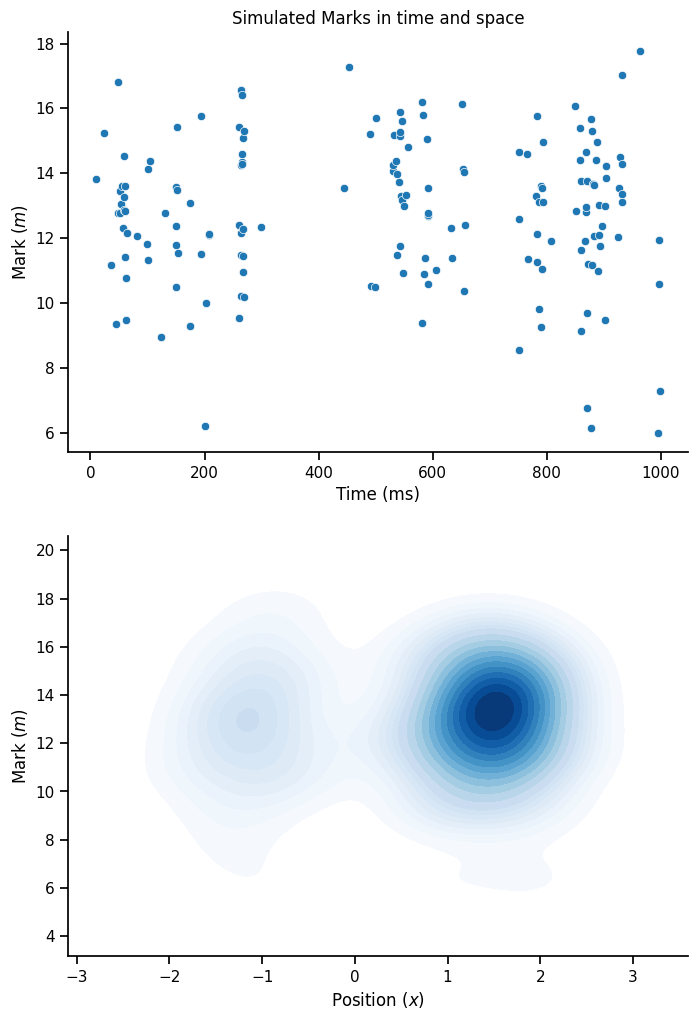

In [9]:
# Rejection sampling
def sample_from_marks_pdf(pdf, m_min, m_max, t, x, mu_x, mu_m, sigma_x, sigma_m, a, n_samples):
    samples = []
    while len(samples) < n_samples:
        m = np.random.uniform(m_min, m_max)  # Sample m uniformly in range
        y = np.random.uniform(0, 1)         # Use 1 as an upper bound for PDF
        if y < pdf(m, t, x, mu_x, mu_m, sigma_x, sigma_m, a):
            samples.append(m)
    return np.array(samples)


# simulating the marks
marks = []
x_spikes = x[np.array(spike_times, dtype = int)]
for t in range(len(spike_times)):
    marks.append(sample_from_marks_pdf(marks_pdf, 0, 20, t, x, mu_x, mu_m, sigma_x, sigma_m, a, 1)[0])


# plotting the marks as a function of time
fig, axs = plt.subplots(2,1, figsize=(8, 12))
sns.scatterplot(x = spike_times, y = marks, ax=axs[0])
sns.kdeplot(x = x_spikes, y = marks, cmap='Blues', fill = True, levels = 20, ax=axs[1])
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Mark $(m)$')
axs[0].set_title('Simulated Marks in time and space')
axs[1].set_xlabel('Position $(x)$')
axs[1].set_ylabel('Mark $(m)$')


sns.despine()
plt.show()





    